Download http://download.tensorflow.org/example_images/flower_photos.tgz

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
from PIL import Image
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

# Cargar imagenes

In [6]:
path = '/home/rhermoza/data/flower_photos/'
img_size = 224
batch_size = 64

In [7]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(path, shuffle=False,
    target_size=(img_size, img_size), batch_size=batch_size)

Found 3670 images belonging to 5 classes.


In [8]:
train_generator.class_indices

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

sunflowers/5223643767_d8beb7e410.jpg


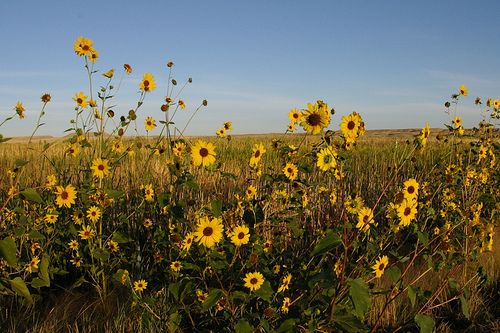

In [9]:
random_img = np.random.choice(train_generator.filenames)
print(random_img)
Image.open(path + random_img)

In [10]:
batch_x, batch_y = train_generator.next()
batch_x.shape, batch_y.shape

((64, 224, 224, 3), (64, 5))

# Cargar la red entrenada

In [11]:
model = ResNet50(include_top=False)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        input_2[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_50 (Activation)      (None, None, None, 6 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [12]:
model.input, model.output

(<tf.Tensor 'input_2:0' shape=(?, ?, ?, 3) dtype=float32>,
 <tf.Tensor 'avg_pool_1/AvgPool:0' shape=(?, ?, ?, 2048) dtype=float32>)

In [13]:
t0 = time()
output = model.predict_on_batch(batch_x)
elapsed = time() - t0
output.shape, elapsed

((64, 1, 1, 2048), 3.673095703125)

In [14]:
print('%.2f minutos por epoch.' % ((train_generator.samples // batch_size) * elapsed / 60))

3.49 minutos por epoch.


# Preprocesar las imagenes con la red entrenada

In [15]:
n_batch = train_generator.samples // batch_size
n_batch

57

In [19]:
train_generator.batch_index

57

In [16]:
train_generator.reset()
outputs_x = []
outputs_y = []

for i in range(n_batch):
    print('%d/%d...' % (i+1, n_batch), end='\r')
    batch_x, batch_y = train_generator.next()
    outputs_x.append(model.predict_on_batch(batch_x))
    outputs_y.append(batch_y)

In [17]:
outputs_x = np.vstack(outputs_x)
outputs_y = np.vstack(outputs_y)
outputs_x.shape, outputs_y.shape

((3648, 1, 1, 2048), (3648, 5))

In [25]:
# Redimensionando
outputs_x = outputs_x[:,0,0,:]
outputs_x.shape, outputs_y.shape

((3648, 2048), (3648, 5))

In [21]:
outputs_x[0], outputs_y[0]

(array([[[ 5.22234154,  0.19048527,  0.47627842, ...,  0.40323192,
           0.02570619,  0.53541142]]], dtype=float32),
 array([ 1.,  0.,  0.,  0.,  0.], dtype=float32))

# Entrenar a partir de los features extraidos

In [41]:
flowers_model = Sequential()
flowers_model.add(Dense(128, activation='relu', input_shape=(2048,)))
flowers_model.add(Dense(5, activation='softmax'))
flowers_model.compile(loss='categorical_crossentropy',
                      optimizer=Adam(0.001),
                      metrics=['accuracy'])
flowers_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 128)               262272    
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 645       
Total params: 262,917
Trainable params: 262,917
Non-trainable params: 0
_________________________________________________________________


In [42]:
log = flowers_model.fit(outputs_x, outputs_y, epochs=5, batch_size=256)

Epoch 1/5
3648/3648 [==============================] - 1s 212us/step - loss: 0.6825 - acc: 0.7508
Epoch 2/5
3648/3648 [==============================] - 0s 12us/step - loss: 0.2402 - acc: 0.9109
Epoch 3/5
3648/3648 [==============================] - 0s 12us/step - loss: 0.1567 - acc: 0.9457
Epoch 4/5
3648/3648 [==============================] - 0s 12us/step - loss: 0.1106 - acc: 0.9677
Epoch 5/5
3648/3648 [==============================] - 0s 12us/step - loss: 0.0807 - acc: 0.9816


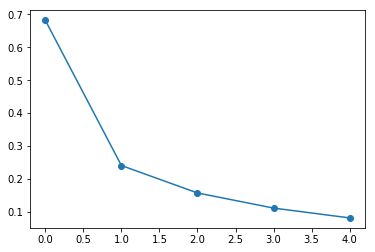

In [43]:
plt.plot(log.history['loss'], '-o');

# Definiendo el modelo completo

In [44]:
base_model = ResNet50(include_top=False)

In [63]:
final_model = Sequential()
final_model.add(base_model)
final_model.add(flowers_model)
final_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, None, None, 2048)  23587712  
_________________________________________________________________
sequential_9 (Sequential)    multiple                  262917    
Total params: 23,850,629
Trainable params: 23,797,509
Non-trainable params: 53,120
_________________________________________________________________


# Usando el modelo

dandelion/921252114_91e334b950.jpg


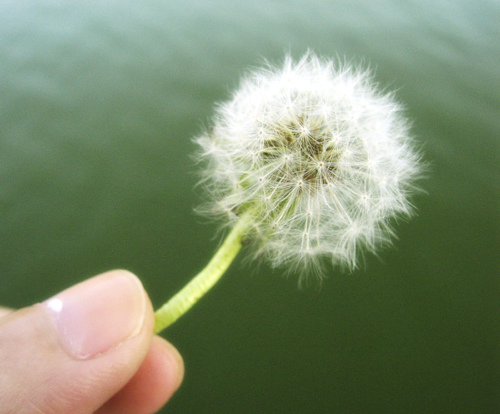

In [64]:
random_img = np.random.choice(train_generator.filenames)
print(random_img)
img = Image.open(path + random_img)
img

In [65]:
# TODO:
# resize img
# pasar a formato de array
# redimensionar
# preprocesar

(1, 224, 224, 3)

In [68]:
# Obtener prediccion

(5,)

In [76]:
# Se crea un diccionario de indice a clase
index2class = {train_generator.class_indices[k]:k for k in train_generator.class_indices}
index2class

{0: 'daisy', 1: 'dandelion', 2: 'roses', 3: 'sunflowers', 4: 'tulips'}

In [77]:
# Usando el diccionario y la funcion np.argmax, obtener el nombre de la clase predecida
index2class[np.argmax()]

'dandelion'

# Resumiendo en una funcion

In [ ]:
def get_class(path):
    # TODO
    return pred

In [ ]:
get_class(np.random.choice(train_generator.filenames))